<h1><center>Sample design - Stress/Strain anisotropy tester</center></h1>

In [1]:
from dolfin import *
from dolfin_adjoint import *
# import pygmsh_mesh_functions
# from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For quality evaluation
from anisotropyv3 import *
from anisotropy_density import *

def UniformityScore(Stress_points,threshold=0.85,tol=1e-14):
    n_discrete = 64   
    Score_Ave = 0.0
    for i in range(n_discrete):
        A=SortCut2(Stress_points,threshold=threshold)
        THETAS=np.sort(np.arctan2(A[:,1],A[:,0]))
        GAPS=np.roll(THETAS,-1,axis=0)%(2*np.pi)
        THETAS_valid = np.sort(THETAS.copy()[GAPS>tol]%(2*np.pi))
        THETAS_valid = THETAS_valid+2*np.pi/len(THETAS_valid)*i/n_discrete
        # counts within each interval
        interval_id = np.round(THETAS_valid/(2*np.pi/len(THETAS_valid))).astype('int')
        bincount = np.bincount(interval_id)
        if (len(THETAS_valid)-len(np.bincount(interval_id)))>0:
            zerobins = np.zeros(len(THETAS_valid)-len(np.bincount(interval_id))) # append zeros
            bincount = np.hstack((bincount,zerobins))
    #     return np.std(bincount)
        if len(bincount)<=2:
            Score = 1.0
        else:
            Score = np.sum(np.abs(bincount-1))/2/(len(bincount)-1)
        Score_Ave+=Score
    Score_Ave/=n_discrete
        
    return Score_Ave

### Parameters for file to test

This is the **only section** you must edit !

For the constitutive model, you may choose between :
- '1-tanhplastic'
- '2-perfectplasticity'


In [2]:
# list available samples
from os import listdir
meshpath = './resultstester_GAP/'
mesh_list = [x for x in listdir(meshpath) if x.endswith('.xdmf')]
mesh_list

['2hole.xdmf',
 '2notch.xdmf',
 'AG03.xdmf',
 'example_2fold.xdmf',
 'example_3fold.xdmf',
 'example_network_2fold.xdmf',
 'example_network_3fold.xdmf',
 'GWO72.xdmf',
 'HarmH27.xdmf',
 'test_array_circle.xdmf',
 'test_array_ellipse.xdmf',
 'test_clover.xdmf',
 'test_clover_rand.xdmf',
 'test_dumbell.xdmf',
 'test_dumbell_45.xdmf',
 'test_dumbell_BF3.xdmf',
 'test_loop_array_2fold.xdmf',
 'test_loop_array_3fold.xdmf',
 'test_NPR.xdmf',
 'test_NPR_rounded.xdmf',
 'test_NPR_rounded_45.xdmf',
 'test_NPR_rounded_90.xdmf',
 'test_NPR_rounded_h.xdmf',
 'test_NPR_rounded_rand.xdmf',
 'test_NPR_rounded_swivel.xdmf',
 'test_NPR_rounded_v.xdmf',
 'test_simplehole_discA1.xdmf',
 'test_simplehole_discA2.xdmf',
 'test_simplehole_discB1.xdmf',
 'test_simplehole_ellipseA12.xdmf',
 'test_simplehole_rectangleA12.xdmf',
 'test_simplehole_squareA1.xdmf',
 'test_simplehole_squareA2.xdmf',
 'test_simplehole_squareB1.xdmf',
 'test_simplehole_triangleAl.xdmf',
 'test_withouthole.xdmf']

5219 elements in mesh


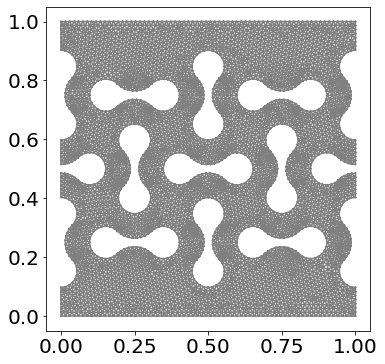

In [3]:
meshfile = "test_NPR_rounded.xdmf"                    # with .xdmf
meshpath = './output_files/'
constitutive_model = '1-tanhplastic'

sample_height=1     #IMPORTANT TO CHECK       #height of the sample in the mesh file (m)

mesh = Mesh()
with XDMFFile(meshpath+meshfile) as xdmf_infile:
    xdmf_infile.read(mesh)
n_elements = mesh.coordinates().shape[0]
print(str(n_elements)+" elements in mesh")

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
plot(mesh)
# ax.set_xlabel('$(\epsilon_x - \epsilon_y)/2$',fontsize=24)
# ax.set_ylabel('$\epsilon_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.set_position([0.2, 0.15, 0.75, 0.75])
plt.savefig('example_mesh.png', dpi=96)

In [4]:
#Test loading profile
T_max = 40                                    #loading time length (s)
e_max = 0.005                                   #max upper boundary strain (no unit)
nb_steps = 15                                 #number of time steps during loading (default is 10)

In [5]:
# Mechanical Properties for sample design evaluation
# (default is given for steel https://www.matweb.com/search/datasheet.aspx?bassnum=MS0001&ckck=1 )

E_float = 200*1e9                                     #Young modulus (Pa)        default 200*1e9
nu_float = 0.25                                       #Poisson ratio (no unit)   default 0.25
sigma_y0_float = 350*1e6                              #Yield stress (Pa)         default 350*1e6

#MODEL PARAMETERS :
    #1-tanhplastic
sp=10
amp=0.1
    #2-perfectplasticity
#no parameters to define
    #3-

In [6]:
# To change the number of discrete segments to calculate anisotropy score :
# (default is 200)
n_seg=200
rel_thresh=1/3

## Plot stress states

### load data

In [7]:
from scipy.io import loadmat
datapath = './resultstester_GAP/'+meshfile+'/'
filename = datapath+'data.mat'
epsilon = loadmat(filename)['epsilon']
sigma = loadmat(filename)['sigma']
n_element = epsilon.shape[0]

In [8]:
n_element = sigma.shape[0]
n_frame = epsilon.shape[3]
strain = np.arange(n_frame)/(n_frame-1)*e_max
i_frame = round(0.001/e_max*(n_frame-1))

epsilon_normal = np.zeros((n_element,n_frame))
epsilon_shear = np.zeros((n_element,n_frame))
sigma_normal = np.zeros((n_element,n_frame))
sigma_shear = np.zeros((n_element,n_frame))

for it in tqdm(range(n_frame)):
    epsilon_t = epsilon[:,:,:,it].reshape(n_element,4)
    epsilon_normal[:,it] = (epsilon_t[:,0] - epsilon_t[:,3])/2
    epsilon_shear[:,it] = epsilon_t[:,2]

    sigma_t = sigma[:,:,:,it].reshape(n_element,4)
    sigma_normal[:,it] = (sigma_t[:,0] - sigma_t[:,3])/2
    sigma_shear[:,it] = sigma_t[:,2]

epsilon_radius2 = (epsilon_normal**2 + epsilon_shear**2).reshape(n_frame*n_element).tolist()
epsilon_all = np.vstack((epsilon_normal.reshape(n_frame*n_element),epsilon_shear.reshape(n_frame*n_element))).T.tolist()
epsilon_i = np.vstack((epsilon_normal[:,i_frame],epsilon_shear[:,i_frame])).T.tolist()

sigma_radius2 = (sigma_normal**2 + sigma_shear**2).reshape(n_frame*n_element).tolist()
sigma_all = np.vstack((sigma_normal.reshape(n_frame*n_element),sigma_shear.reshape(n_frame*n_element))).T.tolist()
sigma_i = np.vstack((sigma_normal[:,i_frame],sigma_shear[:,i_frame])).T.tolist()

thresholds = [1.00, 0.95, 0.75, 0.50, 0.25, 0.05, 0.00]
Score_gap = [GapScore(sigma_i,threshold=x) for x in thresholds]


100%|██████████| 17/17 [00:00<00:00, 3133.10it/s]


### Strain states 2D

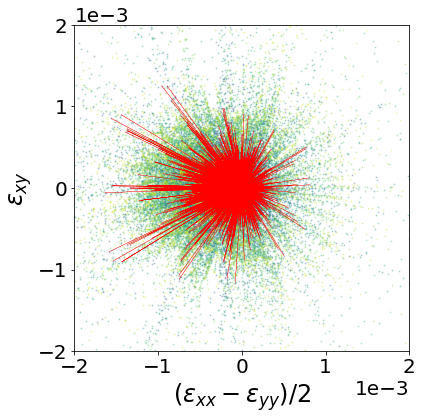

In [9]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = cm.viridis(np.linspace(0, 1, n_frame))

for it in range(n_frame):
    ax.plot(epsilon_normal[:,it],epsilon_shear[:,it],'.',color=colors[it],alpha=0.25,markersize=2)

epsilon_lines = np.vstack((
                    np.vstack((epsilon_normal[:,i_frame],
                           np.zeros_like(epsilon_normal[:,i_frame]))).T.reshape(2*n_element),
                    np.vstack((epsilon_shear[:,i_frame],
                           np.zeros_like(epsilon_shear[:,i_frame]))).T.reshape(2*n_element)
                    ))
    
ax.plot(epsilon_lines[0],epsilon_lines[1],'-',color='r',lw=0.25)

# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-.002, .002)
ax.set_ylim(-.002, .002)
ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1])/500)
ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1])/500)
ax.set_xlabel('$(\epsilon_{xx} - \epsilon_{yy})/2$',fontsize=24)
ax.set_ylabel('$\epsilon_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

### Stress states 2D

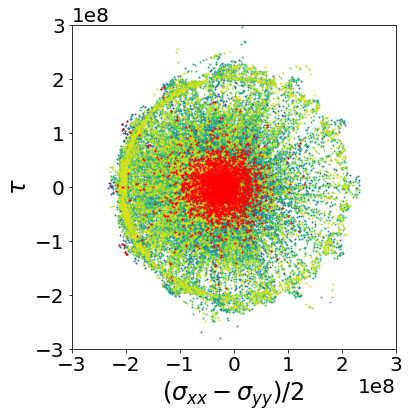

In [10]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = cm.viridis(np.linspace(0, 1, n_frame))

for it in range(n_frame):
    ax.plot(sigma_normal[:,it],sigma_shear[:,it],'.',color=colors[it],alpha=1,markersize=2)

sigma_lines = np.vstack((
                    np.vstack((sigma_normal[:,i_frame],
                           np.zeros_like(sigma_normal[:,i_frame]))).T.reshape(2*n_element),
                    np.vstack((sigma_shear[:,i_frame],
                           np.zeros_like(sigma_shear[:,i_frame]))).T.reshape(2*n_element)
                    ))
    
# ax.plot(sigma_lines[0],sigma_lines[1],'-',color='r',lw=0.25,alpha=0.25)
ax.plot(sigma_normal[:,i_frame],sigma_shear[:,i_frame],'.',color='r',alpha=1,markersize=2,lw=0.25)

# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-3e8, 3e8)
ax.set_ylim(-3e8, 3e8)
ax.set_xticks(np.array([-3,-2,-1,0,1,2,3])*1e8)
ax.set_yticks(np.array([-3,-2,-1,0,1,2,3])*1e8)
ax.set_xlabel('$(\sigma_{xx} - \sigma_{yy})/2$',fontsize=24)
ax.set_ylabel(r'$\tau$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

ax.set_position([0.2, 0.15, 0.75, 0.75])

# pngname = datapath+'perfect_plast.png'
# plt.savefig(pngname, dpi=96)

### Stress states 3D

In [11]:
# %matplotlib notebook

In [12]:
# from matplotlib import cm
# import mpl_toolkits.mplot3d.art3d as art3d
# fig = plt.figure(figsize=(6,6))
# fig.tight_layout()
# ax = fig.add_subplot(projection='3d')

# ax.view_init(elev=15, azim=33)

# colors = cm.viridis(np.linspace(0, 1, n_frame))

# np.random.seed(seed=2)
# n_rays = 1000
# i_rays = np.random.choice(n_element,n_rays)
# # i_rays = np.arange(n_element)

# for it in range(n_frame):
#     ax.scatter(sigma[i_rays,0,0,it],sigma[i_rays,1,1,it],sigma[i_rays,0,1,it],'.',s=.5,color=colors[it],alpha=.5)

# # sigma_lines = np.vstack((
# #                     np.vstack((sigma_normal[:,i_frame],
# #                            np.zeros_like(sigma_normal[:,i_frame]))).T.reshape(2*n_element),
# #                     np.vstack((sigma_shear[:,i_frame],
# #                            np.zeros_like(sigma_shear[:,i_frame]))).T.reshape(2*n_element)
# #                     ))
    
# # ax.plot(sigma_lines[0],sigma_lines[1],'-',color='r',lw=0.25,alpha=0.25)
# # ax.plot(sigma_normal[:,i_frame],sigma_shear[:,i_frame],'.',color='r',alpha=1,markersize=2,lw=0.25)

# # print('rho = {:0.4f}'.format(corr[0,1]))
    
# # ax.set_xlim(-.0012, .0012)
# # ax.set_ylim(-.0012, .0012)
# # ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1])*3e8)
# # ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1])*3e8)
# ax.set_ylabel('$\sigma_{xx}$',fontsize=20)
# ax.set_ylabel('$\sigma_{yy}$',fontsize=20)
# ax.set_ylabel(r'$\tau$',fontsize=20)
# ax.tick_params(which='both', labelsize=18)
# ax.ticklabel_format(scilimits=(0,0))
# ax.xaxis.offsetText.set_fontsize(20)
# ax.yaxis.offsetText.set_fontsize(20)

# ax.set_position([0.2, 0.15, 0.75, 0.75])

# # pngname = datapath+'perfect_plast_3D.png'
# # plt.savefig(pngname, dpi=96)

In [13]:
sigma.shape

(5219, 2, 2, 17)

### Strain states elastic

In [14]:
# ## Plot Demo
# from matplotlib import cm
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)

# percentage = 50/100

# from matplotlib.patches import Circle, Wedge, Polygon
# circle_rmax = Wedge((0,0),1,0,360,width=percentage,fc='teal',alpha=0.5)

# ax.add_patch(circle_rmax)

# np.random.seed(seed=2)
# n_rays = n_element
# # i_rays = np.random.choice(n_element,n_rays)
# i_rays = np.arange(n_element)
# # colors = cm.viridis(np.linspace(0, 1, n_frame))

# # for it in range(n_frame):
# #     ax.plot(epsilon_normal[:,it],epsilon_shear[:,it],'.',color=colors[it],alpha=0.25,markersize=2)
# r = np.sqrt(epsilon_normal[i_rays,i_frame]**2+epsilon_shear[i_rays,i_frame]**2)
# max_r = np.max(r)
# epsilon_lines = np.vstack((
#                     np.vstack((epsilon_normal[i_rays,i_frame],
#                            np.zeros_like(epsilon_normal[i_rays,i_frame]))).T.reshape(2*n_rays),
#                     np.vstack((epsilon_shear[i_rays,i_frame],
#                            np.zeros_like(epsilon_shear[i_rays,i_frame]))).T.reshape(2*n_rays)
#                     ))/max_r

# i_valid = i_rays[r/max_r>= 1-percentage]

# epsilon_lines_valid = np.vstack((
#                     np.vstack((epsilon_normal[i_valid,i_frame],
#                            np.zeros_like(epsilon_normal[i_valid,i_frame]))).T.reshape(2*len(i_valid)),
#                     np.vstack((epsilon_shear[i_valid,i_frame],
#                            np.zeros_like(epsilon_shear[i_valid,i_frame]))).T.reshape(2*len(i_valid))
#                     ))/max_r

# # ax.plot(epsilon_normal[i_rays,i_frame]/max_r,epsilon_shear[i_rays,i_frame]/max_r,'o',color='k',alpha=1,markersize=4)
# ax.plot(epsilon_normal[i_valid,i_frame]/max_r,epsilon_shear[i_valid,i_frame]/max_r,'o',color='r',alpha=1,markersize=4)
# ax.plot(epsilon_lines[0],epsilon_lines[1],'-',color='r',lw=0.5,alpha=0.4)
# ax.plot(epsilon_lines_valid[0],epsilon_lines_valid[1],'-',color='r',lw=1)

# # print('rho = {:0.4f}'.format(corr[0,1]))
    
# ax.set_xlim(-1.2, 1.2)
# ax.set_ylim(-1.2, 1.2)
# ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
# ax.set_xlabel('$(\epsilon_{xx} - \epsilon_{yy})/2$',fontsize=24)
# ax.set_ylabel('$\epsilon_{xy}$',fontsize=24)
# ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
# ax.xaxis.offsetText.set_fontsize(20)
# ax.yaxis.offsetText.set_fontsize(20)

# ax.set_position([0.125, 0.125, 0.75, 0.75])

# # pngname = 'elast.png'
# # plt.savefig(pngname, dpi=96, bbox_inches='tight')

### Stress states elastic

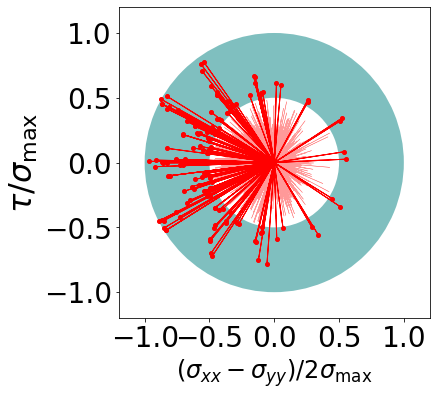

In [35]:
## Plot Demo
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

percentage = 50/100

from matplotlib.patches import Circle, Wedge, Polygon
circle_rmax = Wedge((0,0),1,0,360,width=percentage,fc='teal',alpha=0.5)

ax.add_patch(circle_rmax)

np.random.seed(seed=2)
n_rays = n_element
# i_rays = np.random.choice(n_element,n_rays)
i_rays = np.arange(n_element)
# colors = cm.viridis(np.linspace(0, 1, n_frame))

# for it in range(n_frame):
#     ax.plot(sigma_normal[:,it],sigma_shear[:,it],'.',color=colors[it],alpha=0.25,markersize=2)
r = np.sqrt(sigma_normal[i_rays,i_frame]**2+sigma_shear[i_rays,i_frame]**2)
r50 = np.quantile(r,0.5)
max_r = np.max(r)
sigma_lines = np.vstack((
                    np.vstack((sigma_normal[i_rays,i_frame],
                           np.zeros_like(sigma_normal[i_rays,i_frame]))).T.reshape(2*n_rays),
                    np.vstack((sigma_shear[i_rays,i_frame],
                           np.zeros_like(sigma_shear[i_rays,i_frame]))).T.reshape(2*n_rays)
                    ))/max_r

i_valid = i_rays[r/max_r>= 1-percentage]
# i_valid = i_rays[r>=r50]

sigma_lines_valid = np.vstack((
                    np.vstack((sigma_normal[i_valid,i_frame],
                           np.zeros_like(sigma_normal[i_valid,i_frame]))).T.reshape(2*len(i_valid)),
                    np.vstack((sigma_shear[i_valid,i_frame],
                           np.zeros_like(sigma_shear[i_valid,i_frame]))).T.reshape(2*len(i_valid))
                    ))/max_r

# ax.plot(sigma_normal[i_rays,i_frame]/max_r,sigma_shear[i_rays,i_frame]/max_r,'o',color='k',alpha=1,markersize=4)
ax.plot(sigma_normal[i_valid,i_frame]/max_r,sigma_shear[i_valid,i_frame]/max_r,'o',color='r',alpha=1,markersize=4)
ax.plot(sigma_lines[0],sigma_lines[1],'-',color='r',lw=0.5,alpha=0.4)
ax.plot(sigma_lines_valid[0],sigma_lines_valid[1],'-',color='r',lw=1)

# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel('$(\sigma_{xx} - \sigma_{yy})/2\sigma_{\mathrm{max}}$',fontsize=24)
ax.set_ylabel(r'$\tau/\sigma_{\mathrm{max}}$',fontsize=32)
ax.tick_params(which='both', labelsize=28)
ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

# title_string = "$\mathcal{S}_{\mathrm{cdf}} = "+"{:.2f}".format(Score_gap[3])+"$"
# ax.set_title(title_string, fontsize=24)

ax.set_position([0.25, 0.15, 0.72, 0.72])

pngname = 'example_elast.png'
plt.savefig(pngname, dpi=96)

In [25]:
title_string

'$\\mathcal{S}_{\\mathrm{gap}} = 0.18$'

In [26]:
sigma_valid = np.vstack((sigma_normal[i_valid,i_frame],sigma_shear[i_valid,i_frame])).T

In [27]:
THETAS_0=np.sort(np.arctan2(sigma_valid[:,1],sigma_valid[:,0]))
theta_bar = np.arctan2(np.mean(np.sin(THETAS_0)),np.mean(np.cos(THETAS_0)))
THETAS = np.sort((THETAS_0-theta_bar+np.pi)%(2*np.pi))

In [28]:
THETAS_rep = np.vstack((THETAS,THETAS)).T.reshape(len(THETAS)*2)
THETAS_ext = np.sort(np.concatenate((THETAS_rep, np.array([0,np.pi*2])), axis=0))
CDF = np.arange(len(THETAS)+1)/len(THETAS)
CDF_rep = np.vstack((CDF,CDF)).T.reshape(len(CDF)*2)
CDF_uni = THETAS_ext/2/np.pi

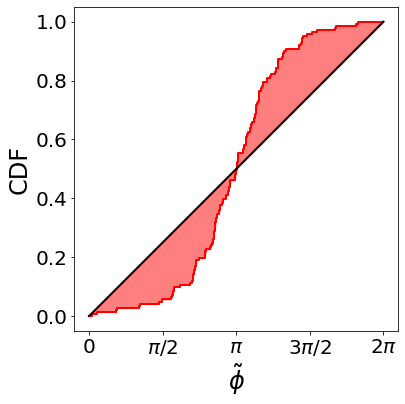

In [31]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
plt.plot(THETAS_ext,CDF_rep,'r',lw=2)
plt.plot(THETAS_ext,CDF_uni,'k',lw=2)
plt.fill_between(THETAS_ext,CDF_rep,CDF_uni,color='r',alpha=0.5)

ax.set_xticks(np.array([0, 0.5, 1, 1.5, 2])*np.pi)
ax.set_xticklabels(['$0$','$\pi/2$','$\pi$','$3\pi/2$','$2\pi$'])

ax.set_xlabel(r'$\tilde{\phi}$',fontsize=24)
ax.set_ylabel('CDF',fontsize=24)
ax.tick_params(which='both', labelsize=20)
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)

ax.set_position([0.2, 0.15, 0.75, 0.75])

pngname = 'example_CDF.png'
plt.savefig(pngname, dpi=96)